In [1]:
#imports
import numpy as np
import numpy.random as rd
import math
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from hmmlearn import hmm

In [2]:
def sample(prob): # BS can be done
    r = rd.random();i = 0
    while r > prob[i]:
        r-=prob[i]
        i+=1
    return i

def bernoulli(prob):
    if rd.random() > prob:
        return 1
    return 0

def row_normalize(arr):
    arr = np.array(arr,float)
    for i in range(np.shape(arr)[0]):
        arr[i] = arr[i]/np.sum(arr[i])
    return arr

def steady_state_prob(matrix):
    """
    This function calculates relative throughput from a probability matrix
    :param matrix: the probability matrix
    :return: A list of relative throughput values
    """
    a_list = []
    b_list = []
    for v in matrix:
        a_list.append(1)
        b_list.append(0)
    b_list.append(1)
    A = np.append(np.transpose(matrix) - np.identity(len(matrix)), [a_list], axis=0)
    b = np.transpose(np.array(b_list))
    return np.linalg.solve(np.transpose(A).dot(A), np.transpose(A).dot(b))

In [3]:
en = 3
ch = 3
P = np.array([[.1, .2, .7],[.5, .3, .2],[.3, .3, .4]])
E = np.array([[.5,.6,.4],[.2,.3,.1],[.4,.5,.3]])
rate = np.array([8.,6.,4.])
# E = np.array([[.6,.9,.3],[.3,.5,.1],[.4,.1,.05]])
# P = row_normalize(np.random.rand(ch,ch)/2)
# E = np.random.rand(en,ch)/2
# rate = np.array([np.random.randint(1,10) for i in range(en)])
lr = 0.01
eps = .5
eps_min = 0.01
print(P)
print(E)
ub = np.sum(E*steady_state_prob(P),axis=1)
print(min(ub))

[[0.1 0.2 0.7]
 [0.5 0.3 0.2]
 [0.3 0.3 0.4]]
[[0.5 0.6 0.4]
 [0.2 0.3 0.1]
 [0.4 0.5 0.3]]
0.18360655737704915


In [6]:
en = 5
ch = 4
# P = np.array([.3,.1,.2,.4])
P = np.array([[.35,.15,.05,.45],[.3,.3,.2,.2],[.3,.4,.1,.2],[.2,.15,.25,.4]])
# P = steady_state_prob(P)
E = np.array([[.4,.6,.4,.3],[.3,.4,.4,.3],[.3,.2,.1,.4],[.1,.35,.3,.4],[.2,.4,.1,.3]])
R = np.array([7.,5.5,4.,6.,5.])
tol = .35
print(P)
print(E)
print(R)
ub = np.sum(E*steady_state_prob(P),axis=1)
print(min(ub))
rate = R

[[0.35 0.15 0.05 0.45]
 [0.3  0.3  0.2  0.2 ]
 [0.3  0.4  0.1  0.2 ]
 [0.2  0.15 0.25 0.4 ]]
[[0.4  0.6  0.4  0.3 ]
 [0.3  0.4  0.4  0.3 ]
 [0.3  0.2  0.1  0.4 ]
 [0.1  0.35 0.3  0.4 ]
 [0.2  0.4  0.1  0.3 ]]
[7.  5.5 4.  6.  5. ]
0.262507237984945


In [7]:
ub = np.sum(E*steady_state_prob(P),axis=1)
ltemp = linprog(c = -1*rate, A_ub = [ub], b_ub = [tol],A_eq = np.ones((1,en)),b_eq = [1.0],method='simplex')
print(np.dot(ltemp.x,rate), np.sum(ltemp.x),ltemp.con, ltemp.success, np.dot(ltemp.x,ub))
print(ltemp.x)
org_lamda = ltemp.x 

6.50100842330051 1.0 [0.] True 0.35
[0.50100842 0.         0.         0.49899158 0.        ]


In [8]:
print(en,ch,tol,np.dot(ltemp.x,rate),min(ub))
print(P)
print(E)
print(ltemp.x)

5 4 0.35 6.50100842330051 0.262507237984945
[[0.35 0.15 0.05 0.45]
 [0.3  0.3  0.2  0.2 ]
 [0.3  0.4  0.1  0.2 ]
 [0.2  0.15 0.25 0.4 ]]
[[0.4  0.6  0.4  0.3 ]
 [0.3  0.4  0.4  0.3 ]
 [0.3  0.2  0.1  0.4 ]
 [0.1  0.35 0.3  0.4 ]
 [0.2  0.4  0.1  0.3 ]]
[0.50100842 0.         0.         0.49899158 0.        ]


In [111]:
lr = 0.001
lr_max = 0.01
eps = .5
eps_min = 0.01
lamda = [np.ones(en)/en]
p = []
# p.append(row_normalize(np.random.rand(ch,ch)))
p.append(row_normalize(np.ones((ch,ch))))
chnl = []; b = [] ; enc = []
emp_rate = [0]; emp_err = [0]
chnl.append(rd.randint(0,ch-1))
enc.append(rd.randint(0,en-1))
b.append(0)
step = 100
t = 0

In [112]:
T = 100000
sprob = steady_state_prob(p[-1])
r = rd.rand()
while t < T:
    if r < max(eps_min,eps/float(t+1)): # put as running eps
        enc.append(rd.randint(0,en))
    else:
        enc.append(sample(lamda[-1]))
    chnl.append(sample(P[chnl[-1]]))
    b.append(bernoulli(E[enc[-1]][chnl[-1]]))
    if (t+1)%step == 0:
        model = hmm.MultinomialHMM(n_components=ch, params='t', init_params='',n_iter=100, tol=1.0e-2)
        model.startprob_ = sprob
        if r < max(eps_min,eps/float(t+1)):
            step_emiss = np.sum(E,axis=0)/3
        else:
            step_emiss = np.sum(np.transpose([lamda[-1]])*E,axis=0)
        model.emissionprob_ = [[step_emiss[i],1-step_emiss[i]] for i in range(ch)]
        model.transmat_ = np.copy(p[-1])
        model.fit([b[-1*step:]])
        temp = np.copy(p[-1])
        lr = min(lr_max,float(step)/(10.0*float(t+1))) # adaptive learning rate
        temp = temp + lr*(model.transmat_-temp) # progressive update
        temp = row_normalize(temp)
        p.append(temp)
        sprob = steady_state_prob(p[-1])
        ub = np.sum(E*sprob,axis=1)
        ltemp = linprog(c = -1*rate, A_ub = [ub], b_ub = [tol],A_eq = np.ones((1,en)),b_eq = [1.0],method='revised simplex',options={'tol': 1.0e-2})
        lamda.append(ltemp.x)
        r = rd.rand()
        emp_err.append(np.dot(ltemp.x,ub))
        emp_rate.append(np.dot(ltemp.x,rate))
        print(t,emp_rate[-1],ltemp.success,lr,)
    t+=1

99 6.45462086758889 True 0.01
199 6.455409520147926 True 0.01
299 6.455395282634773 True 0.01
399 6.458247130286843 True 0.01
499 6.463618704936746 True 0.01
599 6.462920118426968 True 0.01
699 6.4629058341839745 True 0.01
799 6.463014678217911 True 0.01
899 6.463801334317459 True 0.01
999 6.463910311578969 True 0.01
1099 6.4639717941390975 True 0.00909090909090909
1199 6.463552626348035 True 0.008333333333333333
1299 6.463573183786929 True 0.007692307692307693
1399 6.463592227334656 True 0.007142857142857143
1499 6.463609969710241 True 0.006666666666666667
1599 6.463039063999297 True 0.00625
1699 6.465070446804285 True 0.0058823529411764705
1799 6.465130866361299 True 0.005555555555555556
1899 6.465542796408586 True 0.005263157894736842
1999 6.465515097632779 True 0.005
2099 6.465527819831733 True 0.004761904761904762
2199 6.464036936905687 True 0.004545454545454545
2299 6.464686237093794 True 0.004347826086956522
2399 6.464697345776572 True 0.004166666666666667
2499 6.464675196277637

In [113]:
# print(p[0])
print('estimated trans\n',p[-1])
print('real trans\n',P)
print('lamda\n',lamda[-1])
# print(sprob)
# print(model.transmat_)

estimated trans
 [[0.26653785 0.25076424 0.24200283 0.24069508]
 [0.26539191 0.24977887 0.24275326 0.24207596]
 [0.26566713 0.24973835 0.24294842 0.24164609]
 [0.26560845 0.24968707 0.24298625 0.24171824]]
real trans
 [[0.35 0.15 0.05 0.45]
 [0.3  0.3  0.2  0.2 ]
 [0.3  0.4  0.1  0.2 ]
 [0.2  0.15 0.25 0.4 ]]
lamda
 [0.46719927 0.         0.         0.53280073 0.        ]


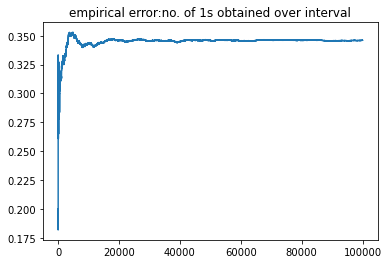

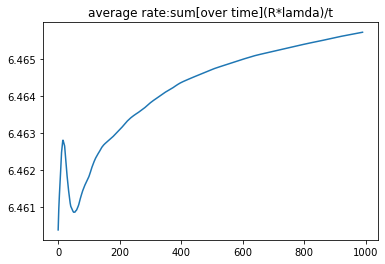

In [114]:
stat = 10
error_plot = 1.0 - np.copy(b)
for i in range(1,len(error_plot)):
    error_plot[i] += (error_plot[i-1]*(i-1))
    error_plot[i] =error_plot[i]/i
plt.plot(error_plot[stat:])
plt.title('empirical error:no. of 1s obtained over interval')
plt.show()
rate_plot = np.copy(emp_rate)
for i in range(1,len(rate_plot)):
    rate_plot[i] += (rate_plot[i-1]*(i-1))
    rate_plot[i] =rate_plot[i]/i
plt.plot(rate_plot[stat:])
plt.title('average rate:sum[over time](R*lamda)/t')
plt.show()

In [115]:
print(rate_plot[-1],error_plot[-1])

6.4657227065114755 0.3459899999999994


0.42961424859981096


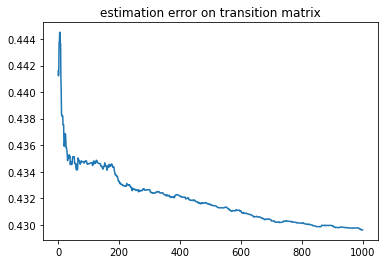

In [130]:
err = []; s = np.shape(P)[0]*np.shape(P)[1]
for i in p:
    err.append(np.sqrt(np.sum(np.square(P-i))))
print(err[-1])
plt.plot(err)
plt.title('estimation error on transition matrix')
plt.show()

[0.2658156  0.25000879 0.24265741 0.24151819]
[0.28025478 0.22321946 0.15894615 0.33757962]
0.13100202908763778


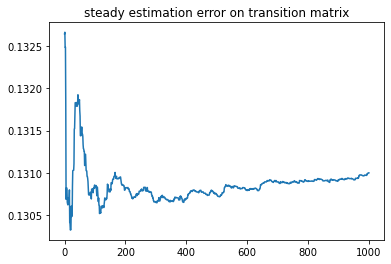

In [117]:
err = []; s = np.shape(P)[0]*np.shape(P)[1]
for i in p:
    err.append(np.sqrt(np.sum(np.square(steady_state_prob(P)-steady_state_prob(i)))))
print(steady_state_prob(p[-1]))
print(steady_state_prob(P))
print(err[-1])
plt.plot(err)
plt.title('steady estimation error on transition matrix')
plt.show()

2.7605061701752973


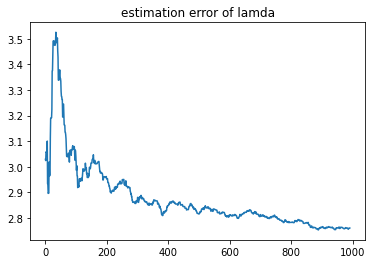

In [118]:
err = []; s = 3
for i in lamda:
    err.append(np.sqrt(np.sum(np.square(org_lamda-i))/s)*100)
print(err[-1])
plt.plot(err[10:])
plt.title('estimation error of lamda')
plt.show()

In [34]:
lamda[-1], org_lamda

(array([0.45153559, 0.        , 0.        , 0.54846441, 0.        ]),
 array([0.50100842, 0.        , 0.        , 0.49899158, 0.        ]))

In [ ]:
# Rough

6.3296


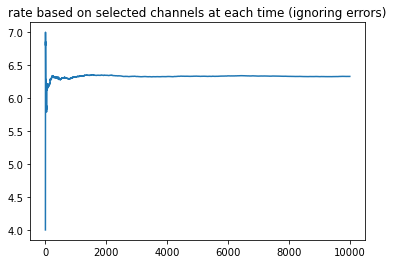

In [12]:
rate_plot = [0]
for i in range(1,len(enc)):
    rate_plot.append((rate_plot[i-1]*(i-1))+rate[enc[i]])
    rate_plot[i] =rate_plot[i]/i
print(rate_plot[-1])
plt.plot(rate_plot[stat:])
plt.title('rate based on selected channels at each time (ignoring errors)')
plt.show()

[0.25216444 0.24466411 0.245235   0.25793646]
[0.28025478 0.22321946 0.15894615 0.33757962]
0.12262845708156352


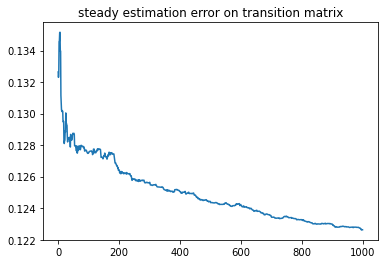

In [129]:
lr = 0.001
lr_max = 0.01
e = 2
chnl = [0];enc = [e];b = [0]
t = 0
p = [row_normalize(np.ones((ch,ch)))]
while t < T:
    enc.append(e)
    chnl.append(sample(P[chnl[-1]]))
    b.append(bernoulli(E[enc[-1]][chnl[-1]]))
    if(t+1)%step == 0:
        model = hmm.MultinomialHMM(n_components=ch, params='t', init_params='',n_iter=100, tol=1.0e-2)
        model.emissionprob_ = [[E[e][i],1-E[e][i]] for i in range(ch)]
        model.startprob_ = steady_state_prob(p[-1])
        model.fit([b[-1*step:]])
        temp = np.copy(p[-1])
        lr = min(lr_max,float(step)/(10.0*float(t+1))) # adaptive learning rate
        temp = temp + lr*(model.transmat_-temp) # progressive update
        temp = row_normalize(temp)
        p.append(temp)
        e = rd.randint(en)
    t+=1
err = []
for i in p:
    err.append(np.sqrt(np.sum(np.square(steady_state_prob(P)-steady_state_prob(i)))))
print(steady_state_prob(p[-1]))
print(steady_state_prob(P))
print(err[-1])
plt.plot(err)
plt.title('steady estimation error on transition matrix')
plt.show()

In [122]:
# reference
model = hmm.MultinomialHMM(n_components=ch, params='t', init_params='',n_iter=100, tol=1.0e-2)
model.emissionprob_ = [[E[e][i],1-E[e][i]] for i in range(ch)]
model.startprob_ = np.ones(ch)/ch
model.fit([b])
# print(model.emissionprob_,model.startprob_)
print(model.transmat_,P)
s = np.shape(P)[0]*np.shape(P)[1]
print('Error',np.sqrt(np.sum(np.square(P-model.transmat_))/s)*100)
print('Steady Error',np.sqrt(np.sum(np.square(steady_state_prob(P)-steady_state_prob(model.transmat_)))))

[[0.27152884 0.2150936  0.17049008 0.34288748]
 [0.26764242 0.22382195 0.18771141 0.32082422]
 [0.26258093 0.23262051 0.20709676 0.2977018 ]
 [0.27440664 0.20653061 0.15516261 0.36390015]] [[0.35 0.15 0.05 0.45]
 [0.3  0.3  0.2  0.2 ]
 [0.3  0.4  0.1  0.2 ]
 [0.2  0.15 0.25 0.4 ]]
Error 8.924904900545814
Steady Error 0.020336368197686527
